# Music-Genre-Classifier Building Deep Learning Model

# 1. Import Dependencies 

In [98]:
import warnings
warnings.filterwarnings('ignore')

# Dependencies
import os 
import urllib
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np 
import random
import cv2
from tqdm import tqdm
import math
from datetime import datetime
import shutil
import imghdr

# Librosa (the mother of audio files)
import librosa
import librosa.display
import IPython.display as ipd
import soundfile as sf

# Audio Augmentation
from audiomentations import (
    Compose,
    
    TimeStretch, 
    Shift, 
    PitchShift, 
    AddGaussianNoise, 
    ApplyImpulseResponse,
    
    # Filters
    BandPassFilter,
    BandStopFilter,
    HighPassFilter,
    HighShelfFilter,
    LowPassFilter,
    LowShelfFilter, 
    PeakingFilter,
    SevenBandParametricEQ,
    
    PolarityInversion,
    Gain,
    TimeMask,
    SpecFrequencyMask
    
)


# Building model
import tensorflow as tf 
import tensorflow_io as tfio
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import relu, sigmoid, softmax, tanh
from tensorflow.keras.layers import Conv2D, Dense, Flatten, BatchNormalization, MaxPool2D,Dropout, Add, AveragePooling2D
from tensorflow.keras.metrics import Recall, Accuracy, Precision
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, LearningRateScheduler,  ReduceLROnPlateau, TensorBoard

# Image augmentation 
import albumentations as A

##  HyperParamters

In [54]:
DATA_DIR = os.path.join('data', 'Data','genres_original')
CLASSES = os.listdir(DATA_DIR)

DATA_GEN_DIR = 'dataset'
TRAIN_DIR = os.path.join(DATA_GEN_DIR, 'train')
TEST_DIR = os.path.join(DATA_GEN_DIR, 'test')

AUGMENTATION_MULTIPLIER = 3
AUGMENTATION_IMPULSE_PATH = 'ir'

EXAMPLE_FILE = os.path.join(DATA_DIR,'blues', 'blues.00000.wav') 
CLASSES

['reggae',
 'metal',
 'disco',
 'pop',
 'blues',
 'hiphop',
 'classical',
 'rock',
 'country',
 'jazz']

# 2. Data Pre-Processing

📌  **2.0 Data Exploration**  
📌  **2.1 Data Splitting**  
📌  **2.2 Data Data Augmentation**  
📌  **2.3 Build Dataloading Function**  

## 2.0 Data exploration


* **Sound:** sequence of vibrations in varying pressure strengths (y)
* The **sample rate (sr)** is the number of samples of audio carried per second, measured in Hz or kHz


In [32]:
y, sr = librosa.load(EXAMPLE_FILE)

print('y:', y)
print('y shape:', np.shape(y))
print('Sample Rate (KHz):', sr)
# Verify length of the audio
print('Check Len of Audio:', 661794/22050)

y: [ 0.00732422  0.01660156  0.00762939 ... -0.05560303 -0.06106567
 -0.06417847]
y shape: (661794,)
Sample Rate (KHz): 22050
Check Len of Audio: 30.013333333333332


In [33]:
# Trim leading and trailing silence from an audio signal (silence before and after the actual audio)
audio_file, _ = librosa.effects.trim(y)
# the result is an numpy ndarray
print('Audio File:', audio_file, '\n')
print('Audio File shape:', np.shape(audio_file))

Audio File: [ 0.00732422  0.01660156  0.00762939 ... -0.05560303 -0.06106567
 -0.06417847] 

Audio File shape: (661794,)


2D Representation: Sound Waves

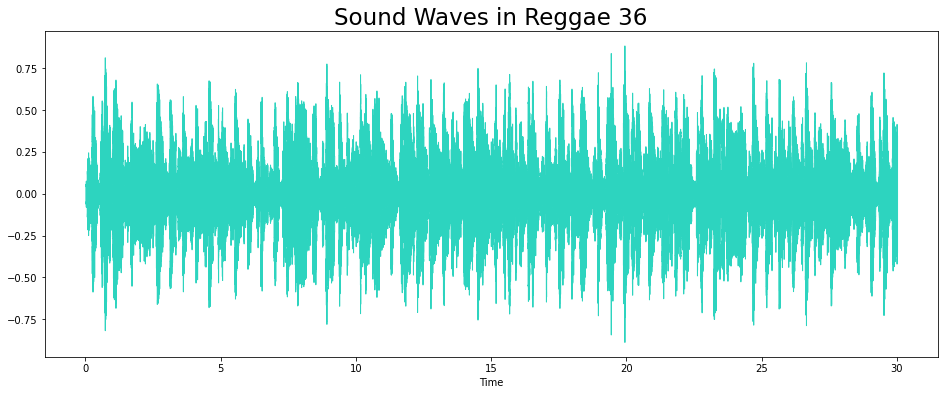

In [34]:
plt.figure(figsize = (16, 6))
librosa.display.waveshow(y = audio_file, sr = sr, color = "#2dd4bf");
plt.title("Sound Waves in Reggae 36", fontsize = 23);


Fourier Transform

* Function that gets a signal in the time domain as input, and outputs its decomposition into frequencies
* Transform both the y-axis (frequency) to log scale, and the “color” axis (amplitude) to Decibels, which is approx. the log scale of amplitudes.



Shape of D object: (1025, 1293)


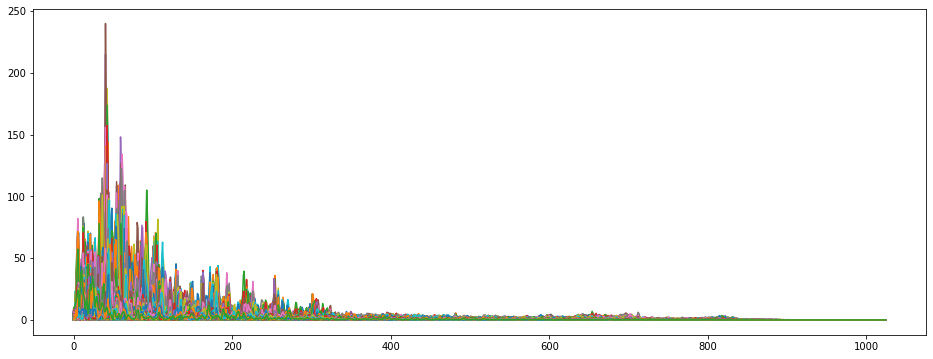

In [36]:
# Default FFT window size
n_fft = 2048 # FFT window size
hop_length = 512 # number audio of frames between STFT columns (looks like a good default)
# Short-time Fourier transform (STFT)
D = np.abs(librosa.stft(audio_file, n_fft = n_fft, hop_length = hop_length))
print('Shape of D object:', np.shape(D))
plt.figure(figsize = (16, 6))
plt.plot(D);

**The Spectrogram**

What is a spectrogram? A spectrogram is a visual representation of the spectrum of frequencies of a signal as it varies with time. When applied to an audio signal, spectrograms are sometimes called sonographs, voiceprints, or voicegrams (wiki).
Here we convert the frequency axis to a logarithmic one.



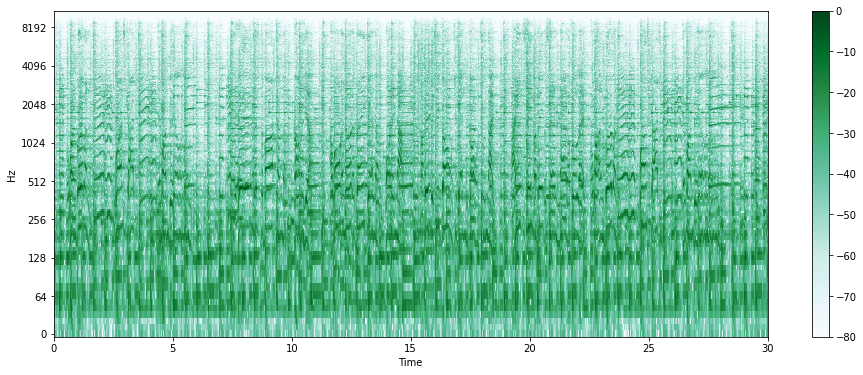

In [37]:
# Convert an amplitude spectrogram to Decibels-scaled spectrogram.
DB = librosa.amplitude_to_db(D, ref = np.max)

# Creating the Spectogram
plt.figure(figsize = (16, 6))
librosa.display.specshow(DB, sr = sr, hop_length = hop_length, x_axis = 'time', y_axis = 'log', cmap = 'BuGn')
plt.colorbar();


## Mel Spectrogram

* The Mel Scale, mathematically speaking, is the result of some non-linear transformation of the frequency scale. The Mel Spectrogram is a normal Spectrogram, but with a Mel Scale on the y axis.



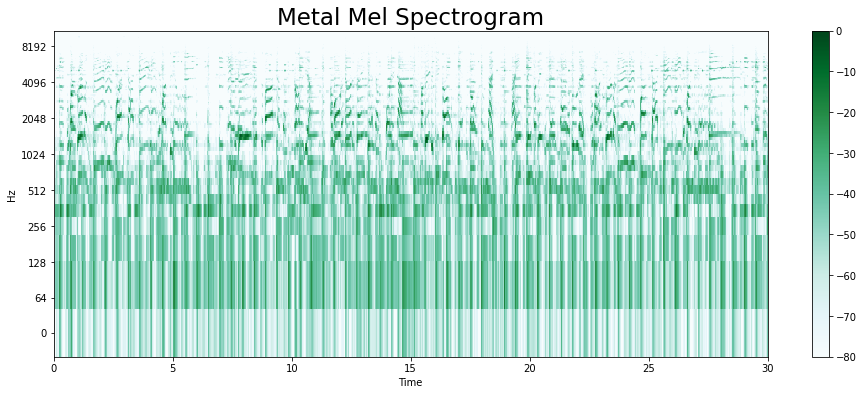

In [39]:
y, sr = librosa.load(EXAMPLE_FILE)
y, _ = librosa.effects.trim(y)


S = librosa.feature.melspectrogram(y, sr=sr)
S_DB = librosa.amplitude_to_db(S, ref=np.max)
plt.figure(figsize = (16, 6))
librosa.display.specshow(S_DB, sr=sr, hop_length=hop_length, x_axis = 'time', y_axis = 'log',
                        cmap = 'BuGn');
plt.colorbar();
plt.title("Metal Mel Spectrogram", fontsize = 23);

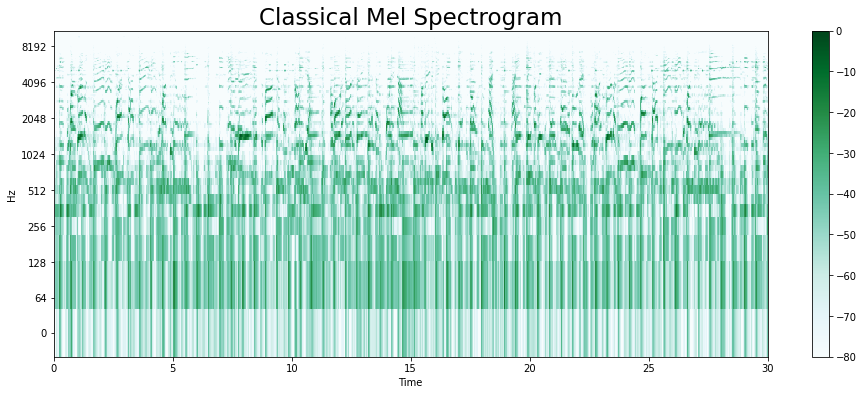

In [43]:
y, sr = librosa.load(EXAMPLE_FILE)
y, _ = librosa.effects.trim(y)

S = librosa.feature.melspectrogram(y, sr=sr)
S_DB = librosa.amplitude_to_db(S, ref=np.max)
plt.figure(figsize = (16, 6))
librosa.display.specshow(S_DB, sr=sr, hop_length=hop_length, x_axis = 'time', y_axis = 'log', cmap = 'BuGn');
plt.colorbar();
plt.title("Classical Mel Spectrogram", fontsize = 23);

## 2.2 Data Augmentation and Data Splitting
📌 Change pitch and speed  
📌 Change pitch only  
📌 Change speed only  
📌 value augmentation  
📌 add distribution noise  
📌 random shifting  
📌 apply hpss  
📌 Shift silent to the right  
📌 Streching  

In [123]:
def reset_augmentation():
    # Remvoe folder and create empty folder 
    if os.path.exists(DATA_GEN_DIR): 
        shutil.rmtree(DATA_GEN_DIR, ignore_errors=True)
    os.makedirs(DATA_GEN_DIR)
    
def reset_train_test():
    training_set = os.path.join(TRAIN_DIR, category)
    testing_set = os.path.join(TEST_DIR, category) 
    os.makedirs(training_set)
    os.makedirs(testing_set)
    
def is_audio_file(audio_dir):
    return audio_dir.lower().endswith(('aifc', 'aiff', 'au', 'hcom', 'sndr', 'sndt', 'voc', 'wav', '8svx', 'sb', 'ub', 'ul'))

def random_uniuqe_audio_name():
    return f'{datetime.timestamp(datetime.now())}_{random.randint(-10000,10000)}.wav'

def audio_augmentation(file_path, save_path):
    for _ in range(AUGMENTATION_MULTIPLIER):
        try:
            augmenter = Compose([
                TimeStretch(min_rate=0.8, max_rate=1.25, p=0.10), 
                Shift(min_fraction=-0.5, max_fraction=0.5, p=0.10), 
                PitchShift(min_semitones=-4, max_semitones=4, p=0.10), 
                AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.10),
                ApplyImpulseResponse( p=0.10,leave_length_unchanged=False, ir_path=AUGMENTATION_IMPULSE_PATH  ),
                
                # Filters
                BandPassFilter(p=0.1),
                BandStopFilter(p=0.1),
                HighPassFilter(p=0.1),
                HighShelfFilter(p=0.1),
                LowPassFilter(p=0.1),
                LowShelfFilter(p=0.1), 
                PeakingFilter(p=0.1),
                SevenBandParametricEQ(p=0.1),
                PolarityInversion(p=0.1),
                Gain(min_gain_in_db=-12, max_gain_in_db=12, p=0.1),
                TimeMask(p=0.1),
            ])
            save_file_path = os.path.join(save_path, random_uniuqe_audio_name() )
            sound_file, sr = librosa.load(file_path)
            augmented_samples = augmenter(samples=sound_file, sample_rate=sr)
            sf.write(save_file_path , augmented_samples, sr , 'PCM_24')
        except:
            print(file_path)
            continue

In [120]:
reset_augmentation()

# Train 80% , Test 20%
for idx,category in tqdm(enumerate(CLASSES)):
    # path to the image
    audio_path = os.path.join(DATA_DIR,category )
    list_audio = os.listdir(audio_path ) 
    train_count = int(len(list_audio)*0.80)
    
    train_audio = list_audio[:train_count]
    test_audio = list_audio[train_count:]
    
    reset_train_test()
    
    for train_audio_name in train_audio:
        train_audio_dir = os.path.join( audio_path ,train_audio_name)
        
        # Check if Audio
        if is_audio_file(train_audio_dir):
            save_dir = os.path.join(TRAIN_DIR, category)
            audio_augmentation(train_audio_dir,save_dir)
            
            # Copy the file to generated file 
            copy_dir = os.path.join(TRAIN_DIR, category, random_uniuqe_audio_name())
            shutil.copy2(train_audio_dir, copy_dir )
            
    for test_audio_name in test_audio:
        test_audio_dir = os.path.join( audio_path ,test_audio_name)
        # Check if Audio
        if is_audio_file(test_audio_dir):
            # Copy the file to generated file 
            copy_dir = os.path.join(TEST_DIR, category, random_uniuqe_audio_name())
            shutil.copy2(test_audio_dir, copy_dir )


10it [06:01, 36.11s/it]


## 2.3 Build MEL-spectogram Function